In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import matplotlib.colors as colors

from nanonets.utils import fft, harmonic_strength, total_harmonic_distortion, sinusoidal_voltages
from scipy import signal
from scipy.spatial import ConvexHull, KDTree
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA

plt.style.use(["science","bright","grid"])
# PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/"
PATH = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/freq_manipulation/"

## Paramter and Input Time Series

In [7]:
N_NP            = 9
N_PERIODS       = 100
N_SAMPLES       = 1280
SAMPLE_P_PERIOD = 40
F0              = 28.0
F0_HZ           = F0 * 1e6
AMPLITUDE       = 0.02
U_BOUNDS        = 0.05
N_EQ_PERIODS    = 20
DT              = 1 / (SAMPLE_P_PERIOD * F0_HZ)
T_SIM           = N_PERIODS / F0_HZ
N_STEPS         = int(np.ceil(T_SIM / DT))

In [8]:
topo    = {"Nx": N_NP,"Ny": N_NP,
           "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
                     [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],
                     [0, N_NP-1],[N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]],
           "electrode_type": ['constant']*8}
time_steps, base_volt = sinusoidal_voltages(N_STEPS, topo,
                                            amplitudes=[AMPLITUDE,0.,0.,0.,0.,0.,0.,0.],
                                            frequencies=[F0_HZ,0.,0.,0.,0.,0.,0.,0.], time_step=DT)
t       = time_steps[:-N_EQ_PERIODS*SAMPLE_P_PERIOD-1]*1e9
x       = base_volt[N_EQ_PERIODS*SAMPLE_P_PERIOD:-1,:][:,0]*1000
y       = pd.read_csv(f"{PATH}/../amp_freq/Nx={N_NP}_Ny={N_NP}_Ne=8_{F0:.3f}_{AMPLITUDE:.3f}_constant.csv")['Observable'].values[N_EQ_PERIODS*SAMPLE_P_PERIOD:]*1e-6
xf, yf  = fft(y, DT)

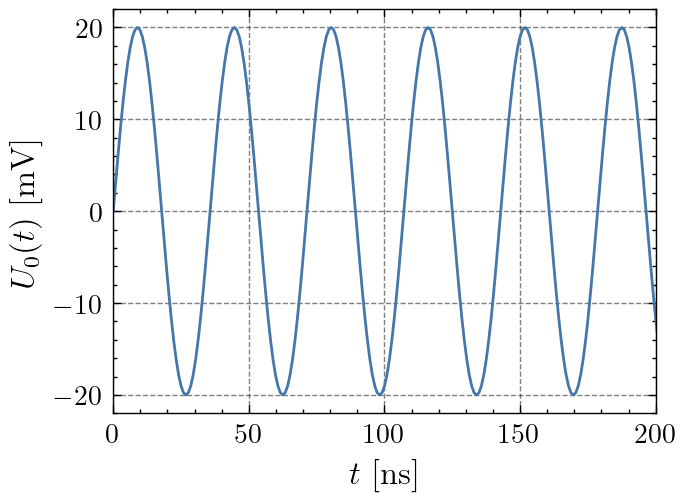

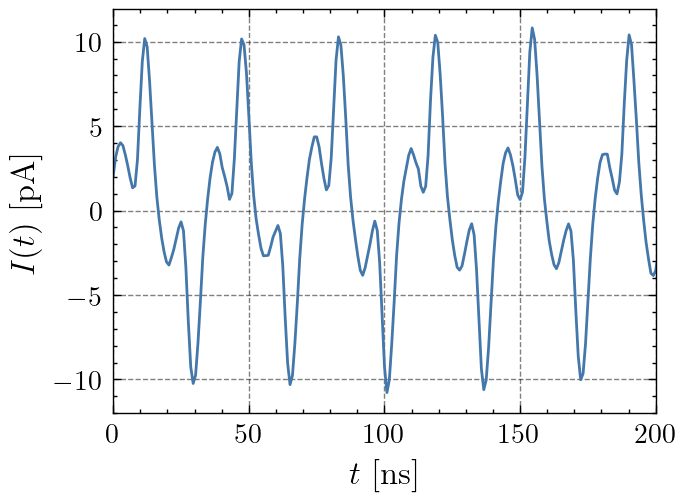

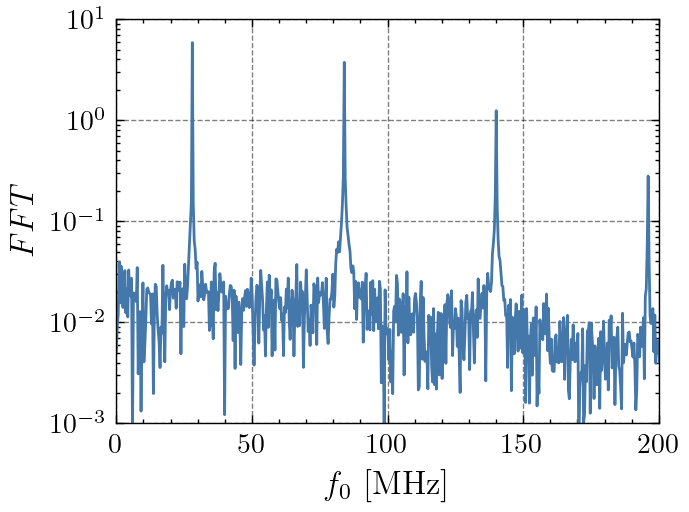

In [23]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, x)
ax.set_ylabel("$U_0(t)$ [mV]", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
ax.set_xlim(0,200)
fig.savefig("plots/freq_manipulation/svg/input_signal.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/input_signal.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/input_signal.png", transparent=False)

fig, ax = plt.subplots(dpi=200)
ax.plot(t, y)
ax.set_ylabel("$I(t)$ [pA]", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
ax.set_xlim(0,200)
fig.savefig("plots/freq_manipulation/svg/output_signal_wo_controls.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/output_signal_wo_controls.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/output_signal_wo_controls.png", transparent=False)

fig, ax = plt.subplots(dpi=200)
ax.plot(xf*1e-6, yf)
ax.set_ylabel("$FFT$", fontsize='large')
ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
ax.set_xlim(0,200)
ax.set_ylim(1e-3,10)
ax.set_yscale('log')
fig.savefig("plots/freq_manipulation/svg/output_fft_wo_controls.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/output_fft_wo_controls.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/output_fft_wo_controls.png", transparent=False)

## Output Time Series and higher harmonics

In [ ]:
data        = {i : pd.read_csv(f"{PATH}Nx={N_NP}_Ny={N_NP}_Ne=8_{i}.csv") for i in range(N_SAMPLES)}
data_new    = [data[i].iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES)]

In [170]:
dim         = 4
hh_vector   = np.array([harmonic_strength(data_new[i], f0=F0_HZ, dt=DT, N_f=dim) for i in range(N_SAMPLES)])

Volume: 0.20471810243611868


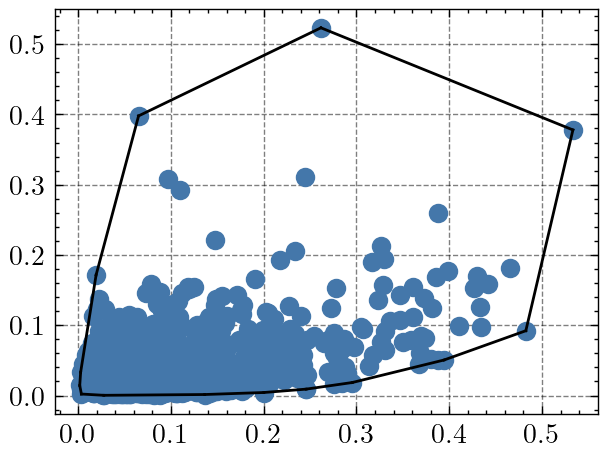

In [169]:
hull    = ConvexHull(hh_vector)
V_hull  = hull.volume
print(f"Volume: {V_hull}")#

fig, ax = plt.subplots(dpi=200)
ax.plot(hh_vector[:,0], hh_vector[:,1], 'o')
for simplex in hull.simplices:
    ax.plot(hh_vector[simplex, 0], hh_vector[simplex, 1], 'k-')

In [171]:
cov_matrix  = np.cov(hh_vector, rowvar=False)
gen_var     = np.linalg.det(cov_matrix)
print(f"Gen Variance: {gen_var}")

Gen Variance: 8.284554835330892e-15


In [189]:
def MC_effective_volume(points, M_samples, d_factor=0.5):
    
    # Define Distance
    pairwise_d  = pdist(points)
    d_radius    = d_factor * np.median(pairwise_d)

    # Define bounding box
    min_bounds  = points.min(axis=0)
    max_bounds  = points.max(axis=0)
    side_length = max_bounds - min_bounds
    v0_volume   = np.prod(side_length)

    # Generate Samples
    samples = np.random.rand(M_samples, points.shape[1])
    samples = samples * side_length + min_bounds

    # Neighbor search
    tree        = KDTree(points)
    d_to_nn, _  = tree.query(samples, k=1)
    hits        = np.sum(d_to_nn <= d_radius)

    # Effective Volume
    p_hit_rate  = hits / M_samples
    v_mc_eff    = p_hit_rate * v0_volume

    return v_mc_eff

M_samples   = [1e3,1e4,1e5,1e6]
d_mc_vals   = np.linspace(0.1,0.9,21)
V_mc_effs   = [[MC_effective_volume(hh_vector, int(M), d) for d in d_mc_vals] for M in M_samples]

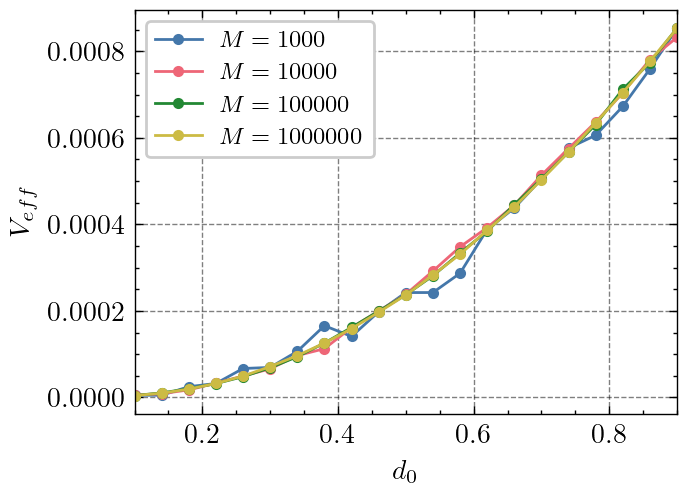

In [ ]:
fig, ax = plt.subplots(dpi=200)
# ax.hlines(V_hull, d_vals[0], d_vals[-1], color='black', ls='--', label='$V_{hull}$')
for i, M in enumerate(M_samples):
    ax.plot(d_mc_vals, V_mc_effs[i], '.-', label=f'$M = {int(M)}$')
ax.set_xlim(d_mc_vals[0], d_mc_vals[-1])
ax.set_xlabel("$d_0$")
ax.set_ylabel("$V_{eff,MC}$")
# ax.set_ylim(1e-3)
# ax.set_yscale('log')
ax.legend(fontsize='small')

In [192]:
def KDE_effective_volume(points, M_samples, density_percentile=0.05):
    
    # Fit KDE and get Desity
    kde                 = gaussian_kde(points.T, bw_method='scott')
    densities_at_points = kde(points.T)
    density_threshold   = np.quantile(densities_at_points, density_percentile)

    # Define bounding box
    min_bounds  = points.min(axis=0) #- 3 * points.std(axis=0)
    max_bounds  = points.max(axis=0) #+ 3 * points.std(axis=0)
    side_length = max_bounds - min_bounds
    v0_volume   = np.prod(side_length)

    # Generate Samples
    samples = np.random.rand(M_samples, points.shape[1])
    samples = samples * side_length + min_bounds

    # Eval density for all Samples
    sample_densities = kde(samples.T)
    
    # Effective Volume
    hits        = np.sum(sample_densities >= density_threshold)
    p_hit_rate  = hits / M_samples
    v_kde_eff   = p_hit_rate * v0_volume

    return v_kde_eff

M_samples   = [1e3,1e4,1e5,1e6]
d_kde_vals  = np.linspace(0.0,0.5,11)
V_kde_effs  = [[KDE_effective_volume(hh_vector, int(M), d) for d in d_kde_vals] for M in M_samples]

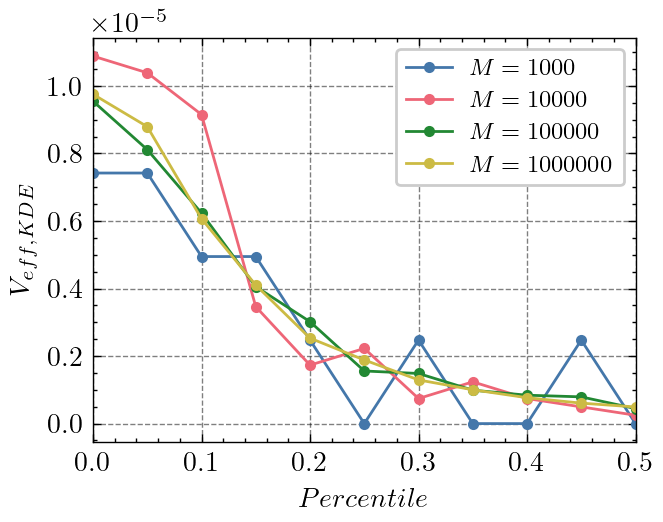

In [193]:
fig, ax = plt.subplots(dpi=200)
# ax.hlines(V_hull, d_vals[0], d_vals[-1], color='black', ls='--', label='$V_{hull}$')
for i, M in enumerate(M_samples):
    ax.plot(d_kde_vals, V_kde_effs[i], '.-', label=f'$M = {int(M)}$')
ax.set_xlim(d_kde_vals[0], d_kde_vals[-1])
ax.set_xlabel("$Percentile$")
ax.set_ylabel("$V_{eff,KDE}$")
# ax.set_ylim(1e-3)
ax.legend(fontsize='small')
# ax.set_yscale('log')

## Total Harmonics Distortion: Max vs Min

In [324]:
dim         = 18
thd_vals    = np.array([total_harmonic_distortion(data_new[i], f0=F0_HZ, dt=DT, N_f=dim) for i in range(N_SAMPLES)])
y_thd       = total_harmonic_distortion(y, f0=F0_HZ, dt=DT, N_f=dim)

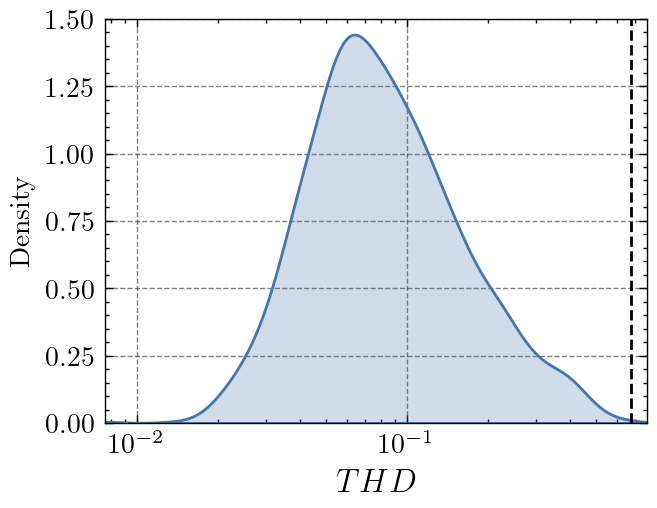

In [325]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(thd_vals, fill=True, log_scale=True)
ax.vlines(y_thd, 0, 1.5, color='black', ls='--')
ax.set_xlim(thd_vals.min(), np.max([thd_vals.max(),y_thd])+0.1)
ax.set_xlabel("$THD$", fontsize='large')
ax.set_ylim(0, 1.5)
fig.savefig("plots/freq_manipulation/svg/thd_dist.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/thd_dist.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/thd_dist.png", transparent=False)

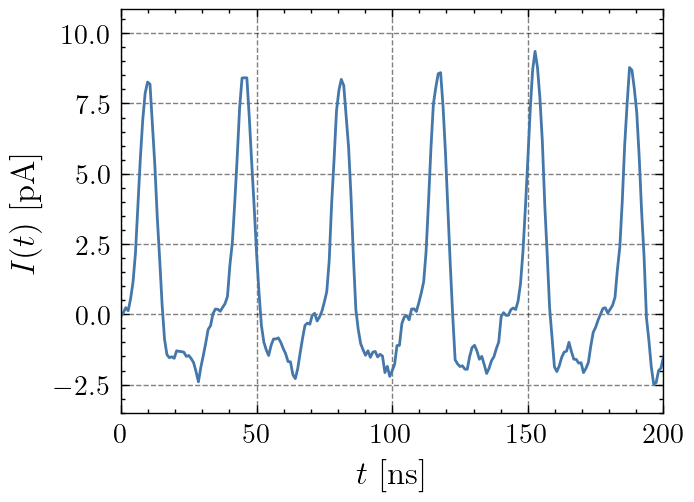

In [326]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, data_new[np.argmax(thd_vals)])
ax.set_ylabel("$I(t)$ [pA]", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
ax.set_xlim(0,200)
fig.savefig("plots/freq_manipulation/svg/output_at_max_thd.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/output_at_max_thd.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/output_at_max_thd.png", transparent=False)

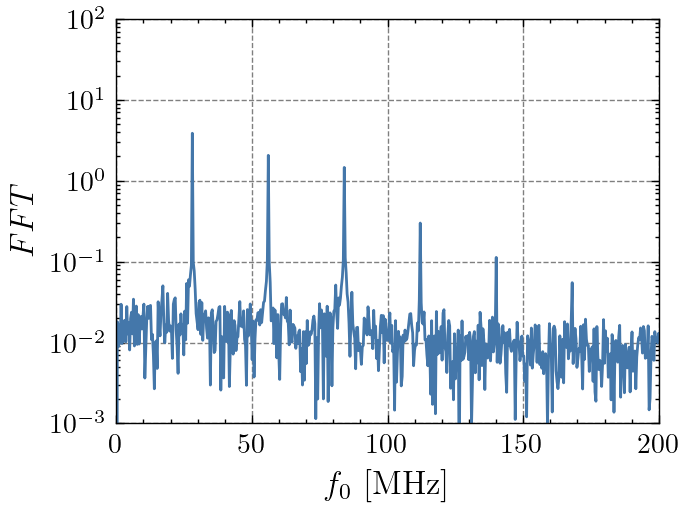

In [327]:
signal   = data_new[np.argmax(thd_vals)].copy()
xf2, yf2 = fft(signal-np.mean(signal), dt=DT)

fig, ax = plt.subplots(dpi=200)
ax.plot(xf2*1e-6, yf2)
ax.set_ylabel("$FFT$", fontsize='large')
ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
ax.set_xlim(0,200)
ax.set_ylim(1e-3,100)
ax.set_yscale('log')
fig.savefig("plots/freq_manipulation/svg/fft_at_max_thd.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/fft_at_max_thd.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/fft_at_max_thd.png", transparent=False)

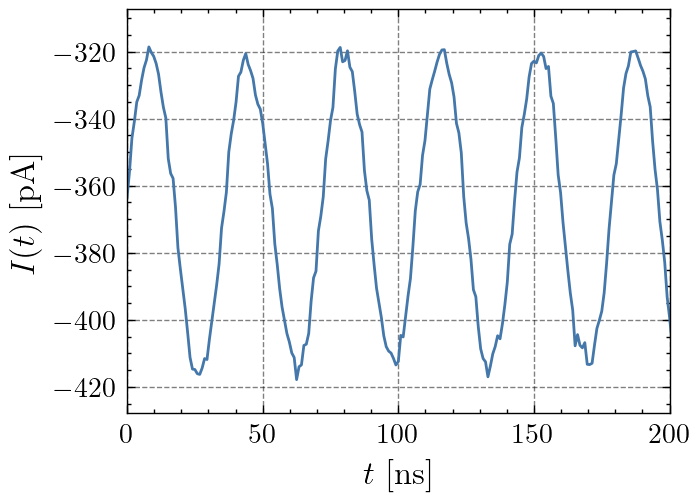

In [328]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, data_new[np.argmin(thd_vals)])
ax.set_ylabel("$I(t)$ [pA]", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
ax.set_xlim(0,200)
fig.savefig("plots/freq_manipulation/svg/output_at_min_thd.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/output_at_min_thd.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/output_at_min_thd.png", transparent=False)

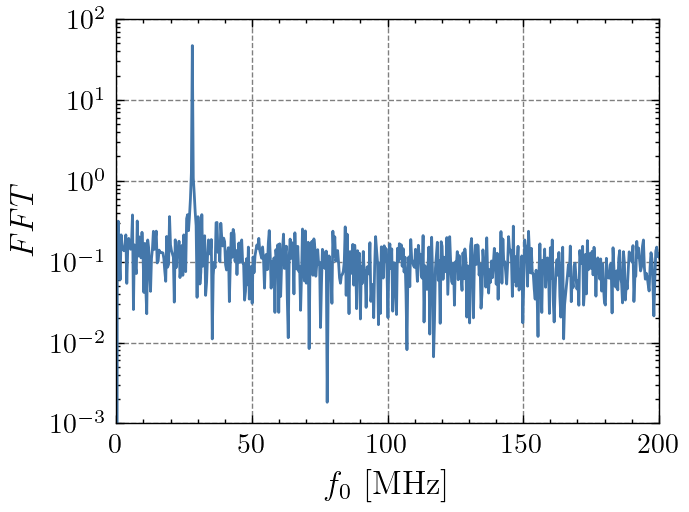

In [329]:
signal   = data_new[np.argmin(thd_vals)].copy()
xf2, yf2 = fft(signal-np.mean(signal), dt=DT)

fig, ax = plt.subplots(dpi=200)
ax.plot(xf2*1e-6, yf2)
ax.set_ylabel("$FFT$", fontsize='large')
ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
ax.set_xlim(0,200)
ax.set_ylim(1e-3,100)
ax.set_yscale('log')
fig.savefig("plots/freq_manipulation/svg/fft_at_min_thd.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/fft_at_min_thd.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/fft_at_min_thd.png", transparent=False)

## Asymmetry

In [322]:
dim         = 18
y_hhs       = harmonic_strength(y, f0=F0_HZ, dt=DT, N_f=dim)
num         = np.sqrt(np.sum(y_hhs[::2]**2))
denom       = np.sqrt(np.sum(y_hhs[1::2]**2))
asym_wo     = num / denom

hh_vector   = np.array([harmonic_strength(data_new[i], f0=F0_HZ, dt=DT, N_f=dim) for i in range(N_SAMPLES)])
num         = np.sqrt(np.sum(hh_vector[:,::2]**2,axis=1))
denom       = np.sqrt(np.sum(hh_vector[:,1::2]**2,axis=1))
asym        = num / denom

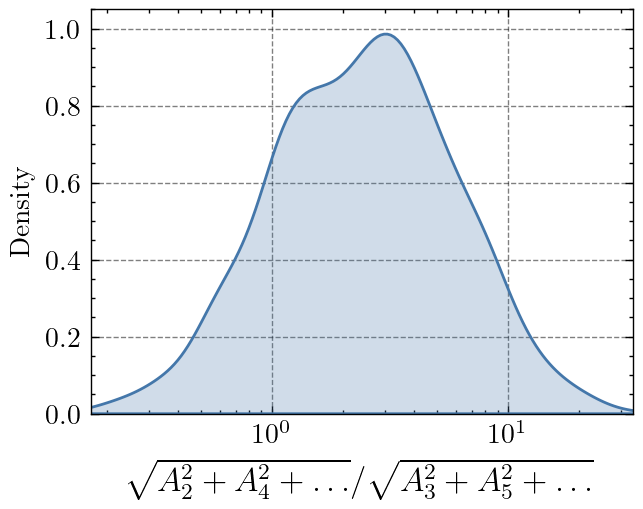

In [323]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(asym, fill=True, log_scale=True)
ax.vlines(asym_wo, 0, 1)
ax.set_xlim(asym.min(), asym.max())
ax.set_xlabel("$\\sqrt{A_2^2 + A_4^2 + \dots} / \\sqrt{A_3^2 + A_5^2 + \dots}$", fontsize='large')
fig.savefig("plots/freq_manipulation/svg/asym_dist.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/asym_dist.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/asym_dist.png", transparent=False)

## Center of Mass

In [319]:
dim         = 18
hh_vector   = np.array([harmonic_strength(data_new[i], f0=F0_HZ, dt=DT, N_f=dim) for i in range(N_SAMPLES)])
num         = np.sum(np.arange(2,dim+2)*hh_vector,axis=1)
denom       = np.sum(hh_vector,axis=1)
center_o_m  = num / denom

y_hhs           = harmonic_strength(y, f0=F0_HZ, dt=DT, N_f=dim)
num             = np.sum(np.arange(2,dim+2)*y_hhs)
denom           = np.sum(y_hhs)
center_o_m_wo   = num / denom

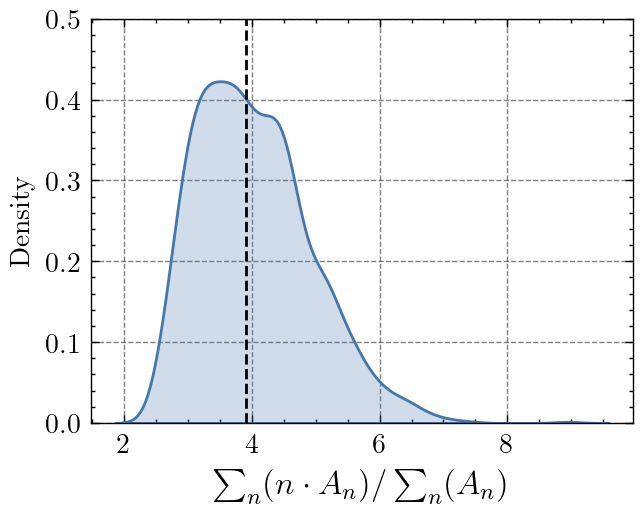

In [321]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(center_o_m, fill=True, log_scale=False)
ax.vlines(center_o_m_wo, 0, 0.5, color='black', ls='--')
ax.set_ylim(0, 0.5)
ax.set_xlabel("$\\sum_n(n \\cdot A_n) / \\sum_n(A_n)$", fontsize='large')
fig.savefig("plots/freq_manipulation/svg/center_of_mass_dist.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/center_of_mass_dist.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/center_of_mass_dist.png", transparent=False)